## EDA

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
columns = ['id_json', 'label', 'statement', 'subject', 
 'speaker', 'speaker_job', 'state', 'party', 
 'barely_true_counts', 'false_counts', 'half_true_counts',
 'mostly_true_counts', 'pants_on_fire_counts', 'context', 'justification']

In [3]:
train = pd.read_csv('dataset/train2.tsv', sep='\t', header=None, index_col=0, names=columns)
val = pd.read_csv('dataset/val2.tsv', sep='\t', header=None, index_col=0, names=columns)
test = pd.read_csv('dataset/test2.tsv', sep='\t', header=None, index_col=0, names=columns)

In [4]:
train.shape, val.shape, test.shape

((10242, 15), (1284, 15), (1267, 15))

In [5]:
df_nans = pd.DataFrame(train.isnull().sum(), columns=['train_nan']).join(
    pd.DataFrame(val.isnull().sum(), columns=['val_nan']).join(
        pd.DataFrame(test.isnull().sum(), columns=['test_nan'])
    )
)

In [6]:
df_nans

,train_nan,val_nan,test_nan
id_json,2,0,0
label,2,0,0
statement,2,0,0
subject,4,0,0
speaker,4,0,0
speaker_job,2899,345,325
state,2210,279,262
party,4,0,0
barely_true_counts,4,0,0
false_counts,4,0,0


In [7]:
train[train.party.isnull()]

,id_json,label,statement,subject,speaker,speaker_job,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,justification
2154.0,638.json,false,The fact is that although we have had a presid...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9404.0,1626.json,false,"Joe, I keep hearing you every morning talking ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Удаляю строчки в train с пустыми statement и party

In [8]:
train.dropna(subset=['statement', 'party'], inplace=True)

In [9]:
df_nans = pd.DataFrame(train.isnull().sum(), columns=['train_nan']).join(
    pd.DataFrame(val.isnull().sum(), columns=['val_nan']).join(
        pd.DataFrame(test.isnull().sum(), columns=['test_nan'])
    )
)

In [10]:
df_nans

,train_nan,val_nan,test_nan
id_json,0,0,0
label,0,0,0
statement,0,0,0
subject,0,0,0
speaker,0,0,0
speaker_job,2895,345,325
state,2206,279,262
party,0,0,0
barely_true_counts,0,0,0
false_counts,0,0,0


In [11]:
# Заполняю пропуски в speaker_job новым значением
train.speaker_job.fillna('no_job_info', inplace=True)
val.speaker_job.fillna('no_job_info', inplace=True)
test.speaker_job.fillna('no_job_info', inplace=True)

# Заполняю пропуски в state новым значением
train.state.fillna('no_state_info', inplace=True)
val.state.fillna('no_state_info', inplace=True)
test.state.fillna('no_state_info', inplace=True)

# Заполняю пропуски в context пустым значением
train.context.fillna('', inplace=True)
val.context.fillna('', inplace=True)
test.context.fillna('', inplace=True)

# Заполняю пропуски в justification пустым значением
train.justification.fillna('', inplace=True)
val.justification.fillna('', inplace=True)
test.justification.fillna('', inplace=True)

In [12]:
true_labels = ['half-true', 'mostly-true', 'true']

Делаю таргет для бинарной классификации

In [13]:
train['true_news'] = train.label.apply(lambda x: 1 if x in true_labels else 0)
val['true_news'] = val.label.apply(lambda x: 1 if x in true_labels else 0)
test['true_news'] = test.label.apply(lambda x: 1 if x in true_labels else 0)

In [14]:
train['data_type'] = 'train'
val['data_type'] = 'val'
test['data_type'] = 'test'

In [15]:
data = pd.concat([train, val, test])

## Распределения признаков

* **Разбиение на train, val, test отличается несильно**
* **Баланс классов более-менее стабилизирован. Но класс с фейковыми новостями меньше**

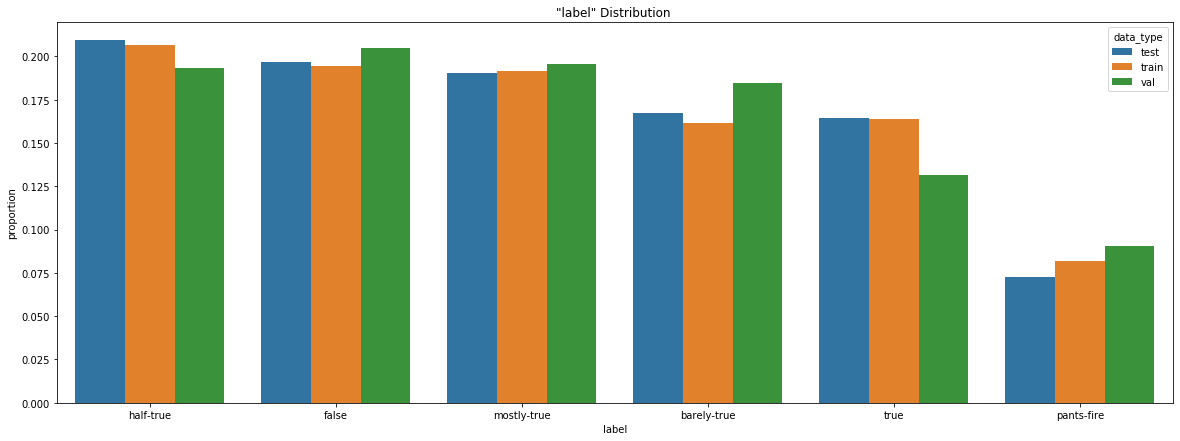

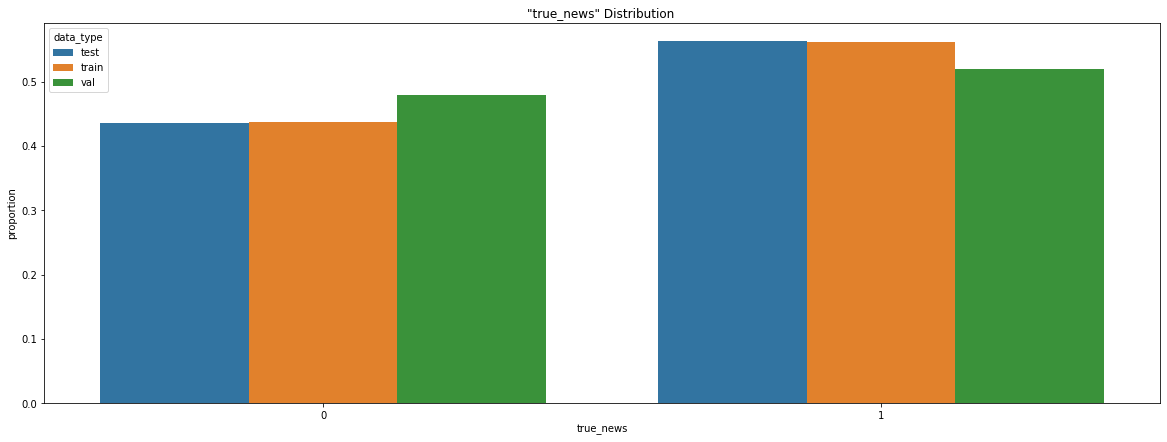

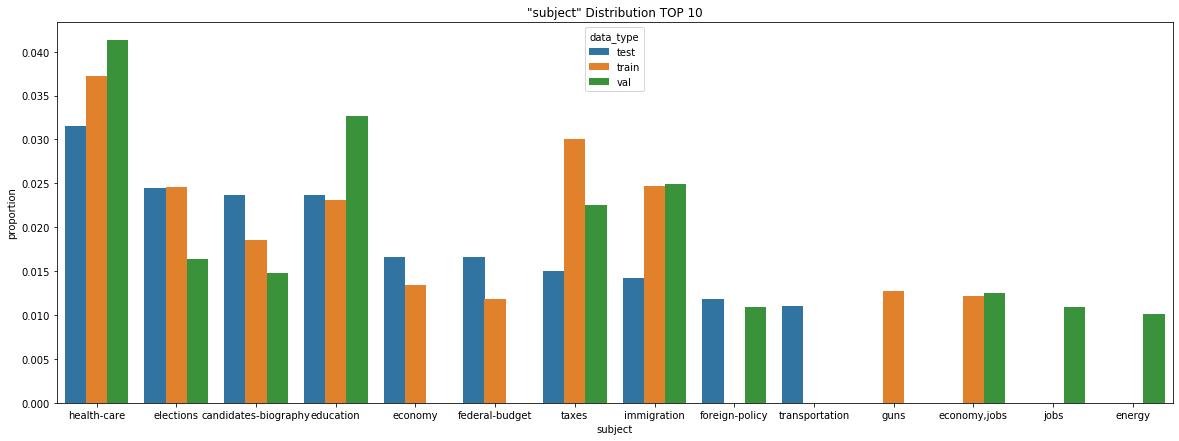

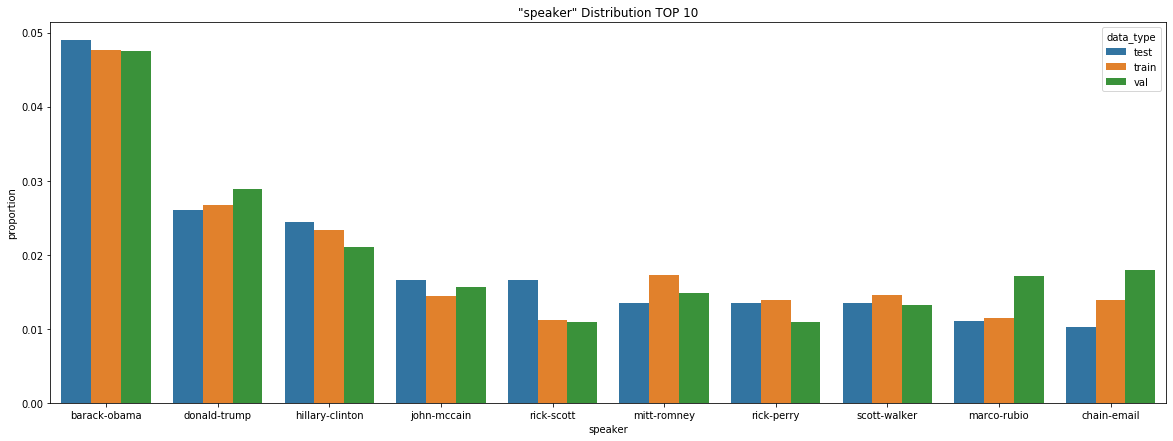

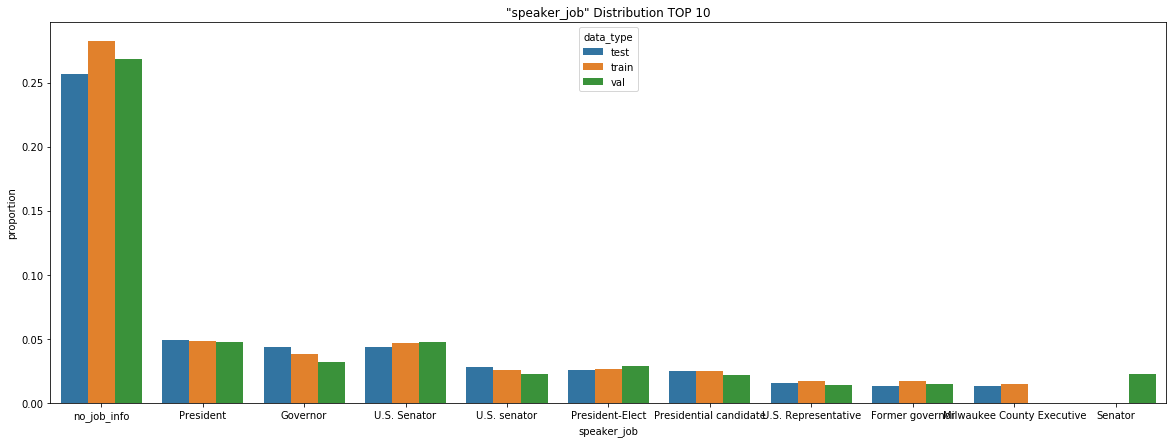

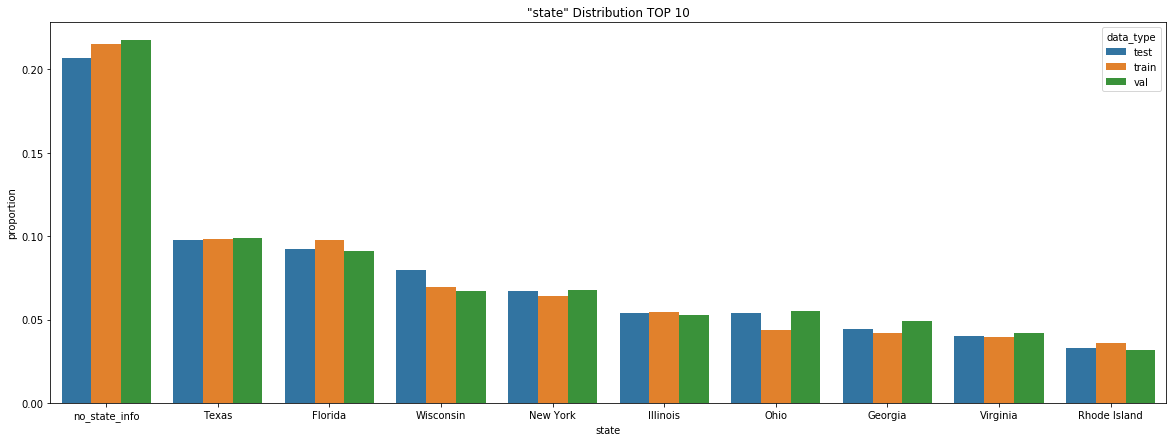

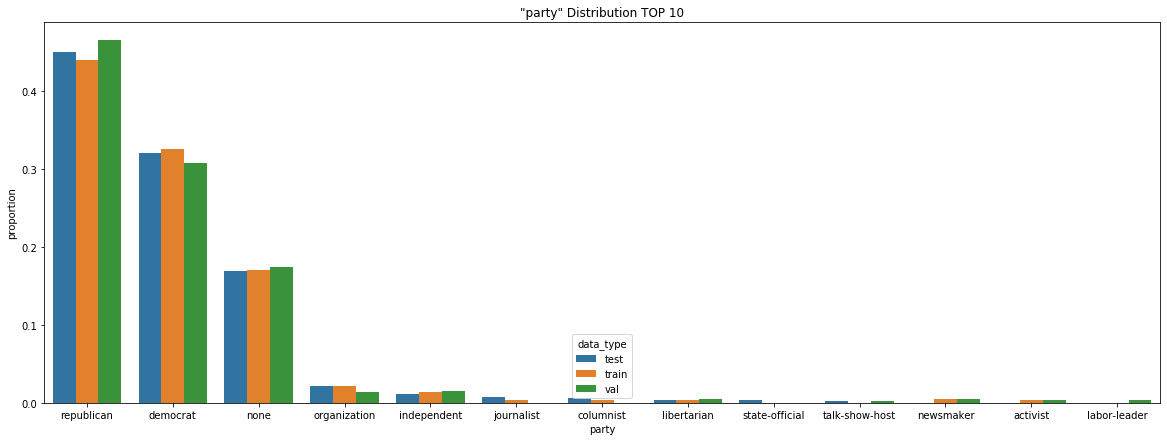

In [16]:
for col in ['label', 'true_news', 'subject', 'speaker', 'speaker_job', 'state', 'party']:
    plt.figure(figsize=(20, 7))
    top_10 = 'TOP 10' if data[col].nunique() > 10 else ''
    plt.title(f'"{col}" Distribution {top_10}')
    (data[col]
     .groupby(data['data_type'])
     .value_counts(normalize=True)
     .groupby('data_type')
     .head(10)
     .rename('proportion')
     .reset_index()
     .pipe((sns.barplot, "data"), x=col, y='proportion', hue='data_type'))
    plt.show()

In [17]:
cat_cols = ['subject', 'speaker', 'speaker_job', 'state', 'party']

Уникальное количество категорий

In [18]:
data[cat_cols].nunique()

subject        4534
speaker        3309
speaker_job    1356
state            86
party            24
dtype: int64

* **subject** представляет собой перечисление топиков новости через запятую. Как кодировть? Эмбеддинги?

In [19]:
data.subject.iloc[:20]

0.0                                      abortion
1.0            energy,history,job-accomplishments
2.0                                foreign-policy
3.0                                   health-care
4.0                                  economy,jobs
5.0                                     education
6.0                          candidates-biography
7.0                                        ethics
8.0                                          jobs
9.0     energy,message-machine-2014,voting-record
10.0                                    elections
11.0      economy,jobs,new-hampshire-2012,poverty
12.0                         history,state-budget
13.0           economy,federal-budget,health-care
14.0                                  health-care
15.0                                    elections
16.0                               federal-budget
17.0                               federal-budget
18.0    financial-regulation,foreign-policy,water
19.0                bankruptcy,economy,population


* **speaker** - Очень много спикеров, у которых мало новостных заголовков в данных. Кодировать one-hot? Отобрать топ спикеров? Нет смысла вводить отдельный признак для спикера, у которого всего 2 новости в данных (например)

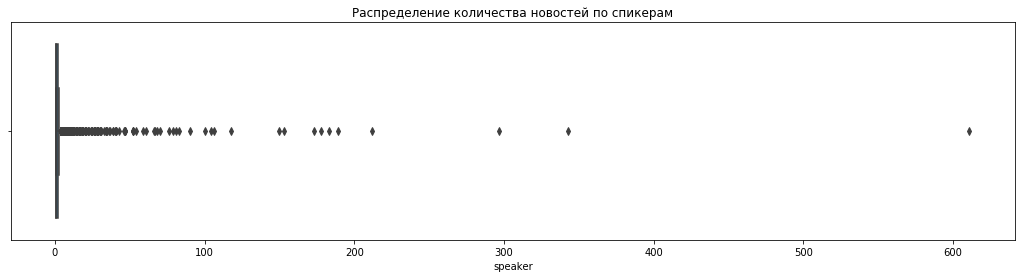

In [20]:
plt.figure(figsize=(18, 4))
plt.title('Распределение количества новостей по спикерам')
sns.boxplot(x=data.speaker.value_counts())
plt.show()

In [21]:
np.percentile(data.speaker.value_counts().values, 50)

1.0

In [22]:
np.percentile(data.speaker.value_counts().values, 90)

6.0

In [23]:
np.percentile(data.speaker.value_counts().values, 95)

11.0

* **speaker_job** - Много уникальных должностей. Эмбеддинги?

* **state** - много дубликатов в данных. Например, Washington, D.C. и Washington

In [24]:
data.state = data.state.apply(lambda x: x.strip())

* **context** - бывает очень подробное описание. Нужно строить эмбеддинги

**Может соединить признаки в одно предложение?**

**Нужно из признаков с историей новостей удалить текущий таргет, чтобы не было утечки!**

In [25]:
targets = ['label', 'true_news']

## Распределение таргета по категориям

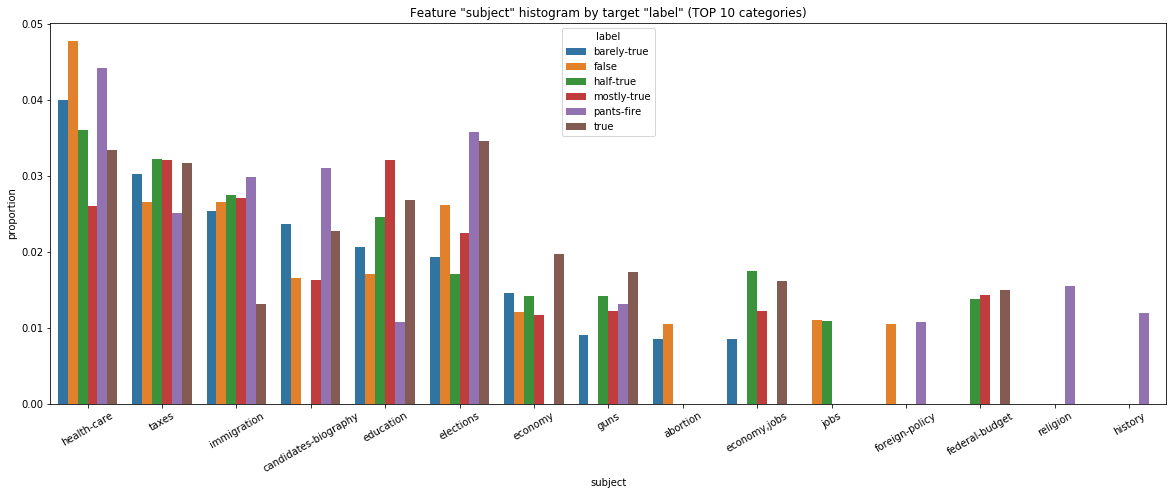

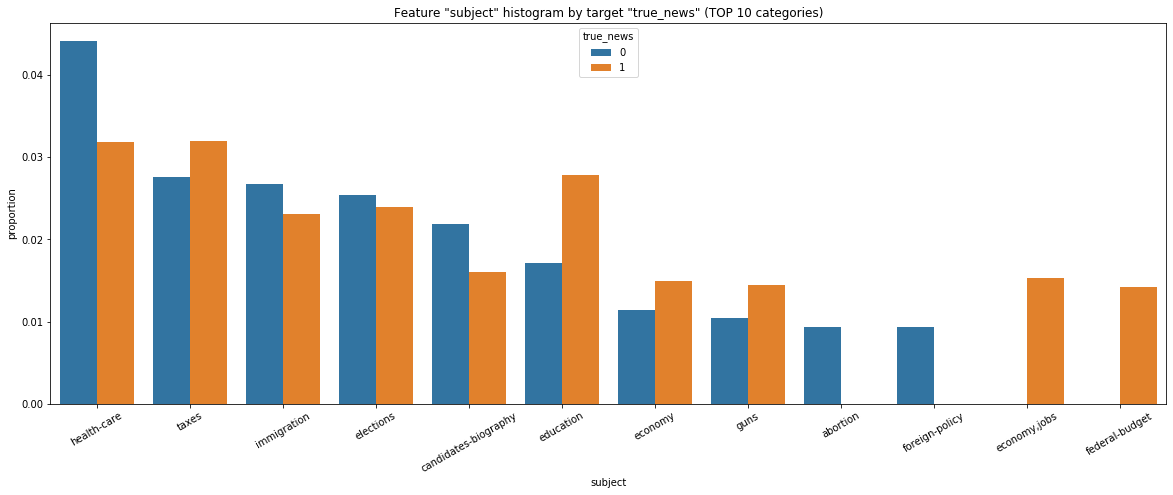

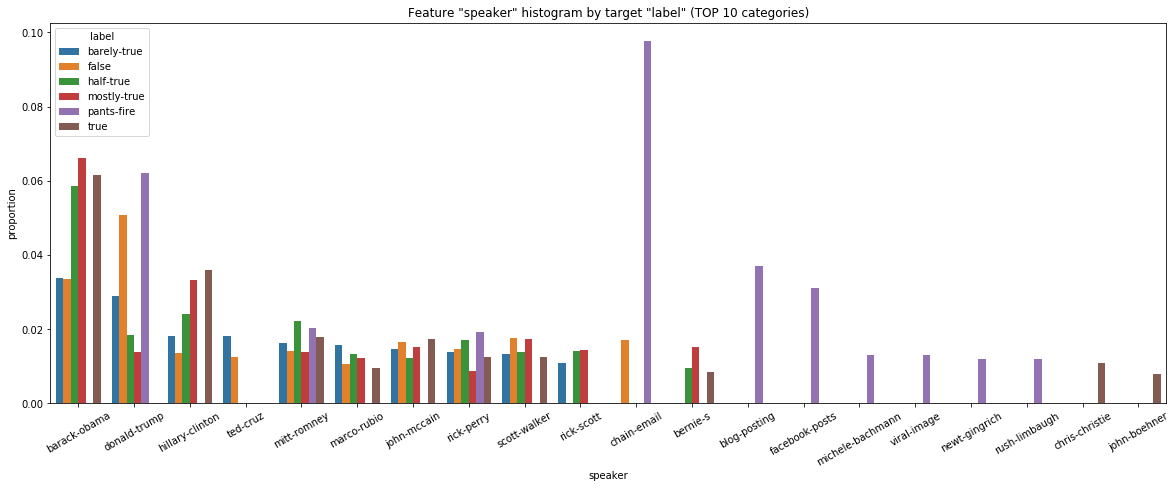

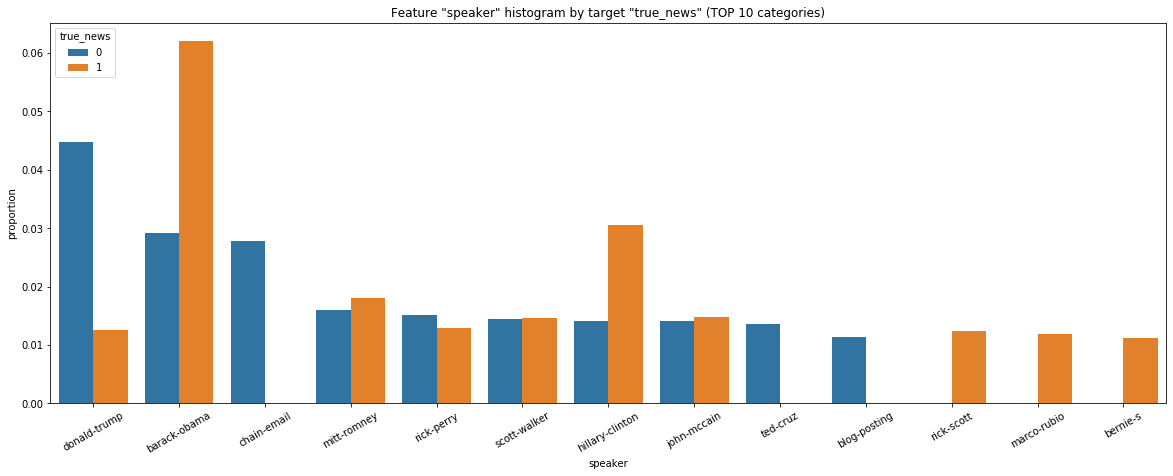

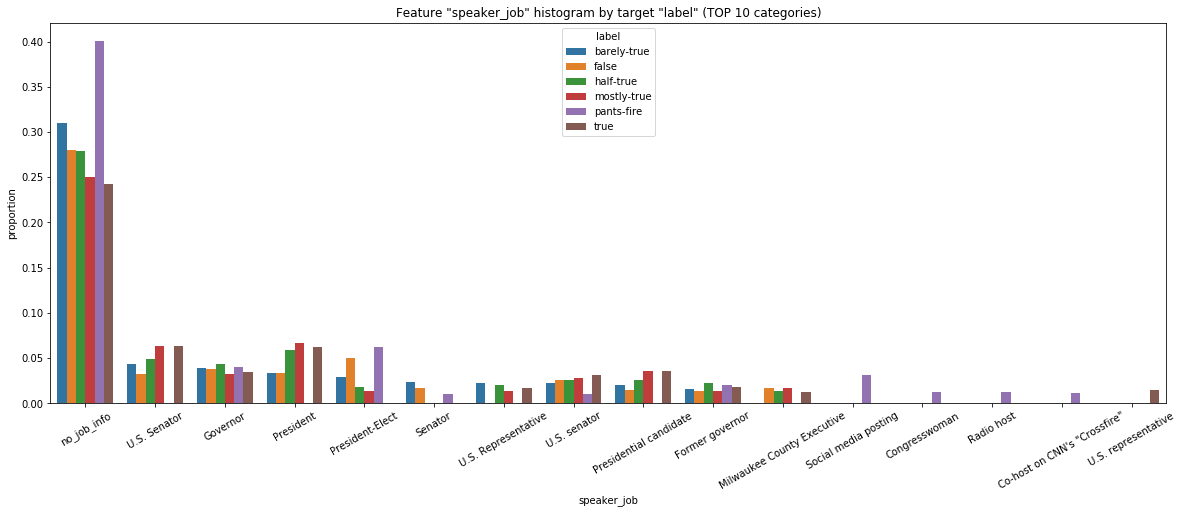

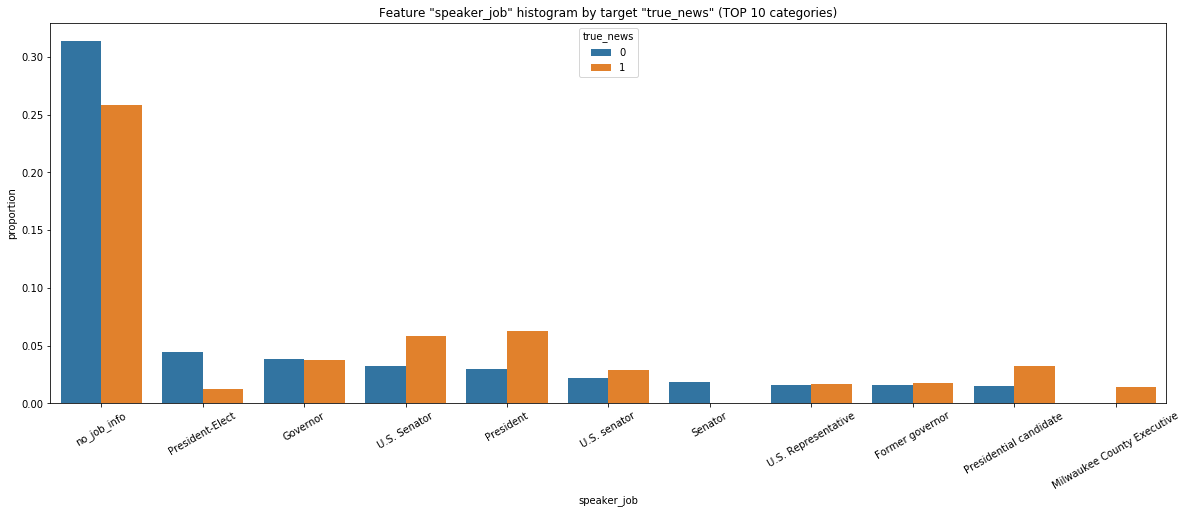

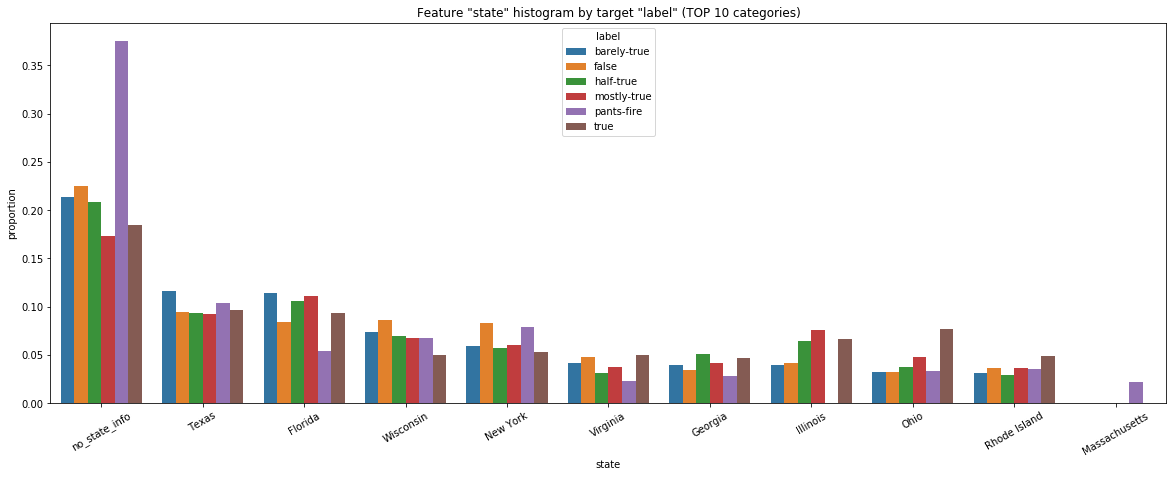

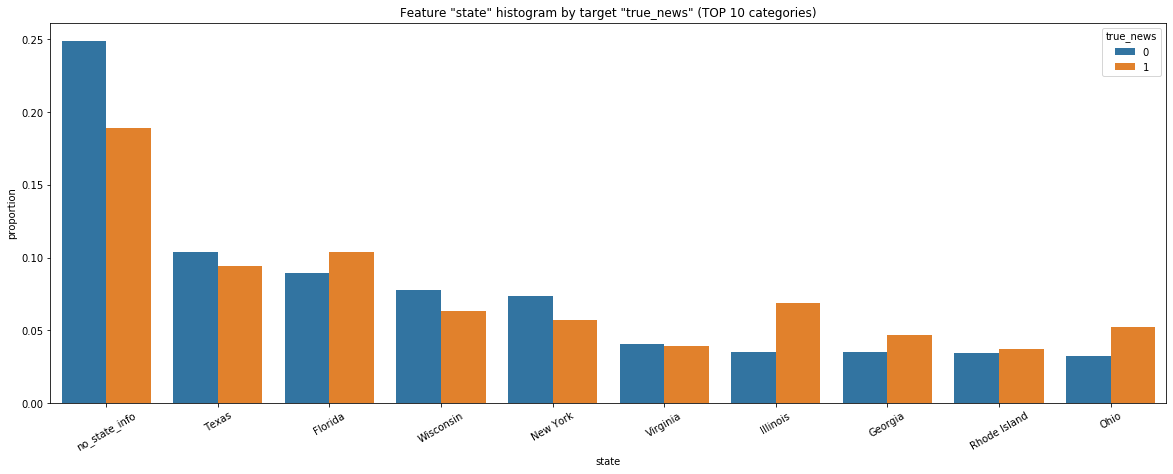

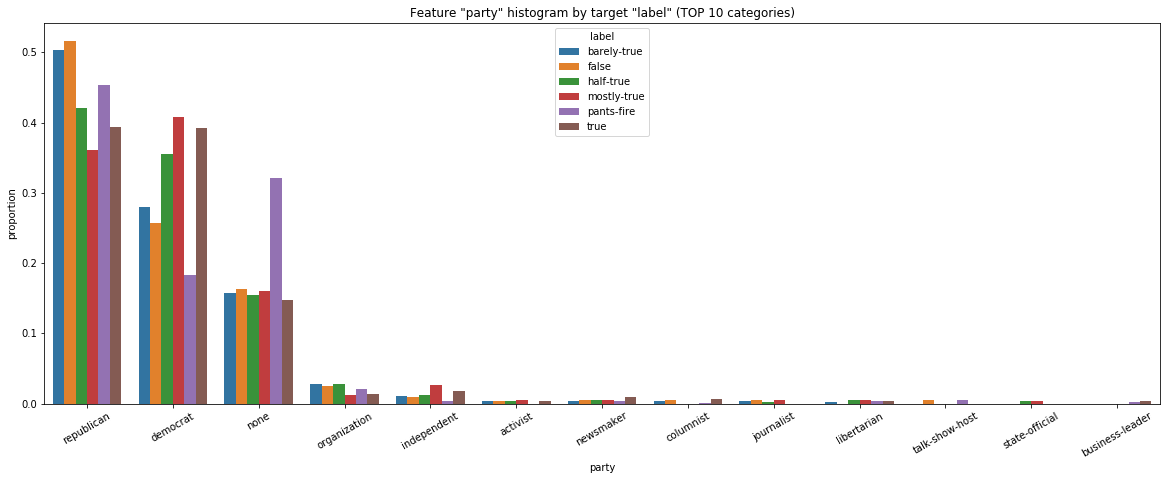

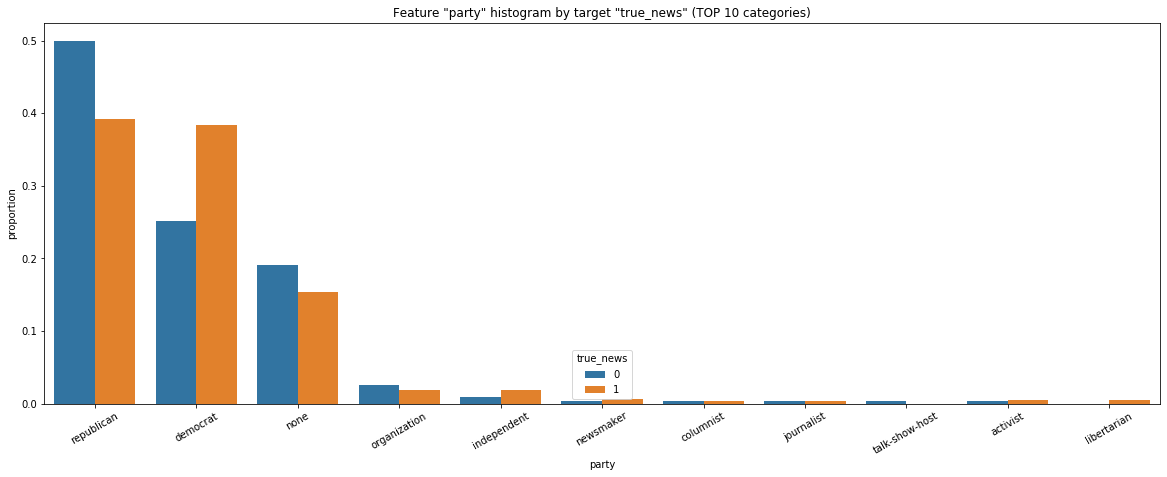

In [26]:
for col in cat_cols:
    for target in targets:
        plt.figure(figsize=(20, 7))
        plt.title(f'Feature "{col}" histogram by target "{target}" (TOP 10 categories)')
        (train[col]
         .groupby(train[target])
         .value_counts(normalize=True)
         .groupby(target)
         .head(10)
         .rename('proportion')
         .reset_index()
         .pipe((sns.barplot, "data"), x=col, y='proportion', hue=target))
        plt.xticks(rotation=30)
        plt.show()

Удаляю из истории текущий таргет

In [27]:
data[['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']] = \
data[['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']].values - \
pd.get_dummies(data.label).drop('true', axis=1).values

In [29]:
data.to_csv('dataset/data_liar_plus.csv', index=False, sep=';')

## Примеры

In [30]:
text_cols = ['statement', 'justification', 'context']

**true**

In [31]:
df = pd.DataFrame(data.query("data_type == 'train'").iloc[16])
df.style.set_properties(**{'text-align': 'left'})

,16.0
id_json,620.json
label,true
statement,McCain opposed a requirement that the government buy American-made motorcycles. And he said all buy-American provisions were quote 'disgraceful.'
subject,federal-budget
speaker,barack-obama
speaker_job,President
state,Illinois
party,democrat
barely_true_counts,70.000000
false_counts,71.000000


**mostly-true**

In [32]:
df = pd.DataFrame(data.query("data_type == 'train'").iloc[2])
df.style.set_properties(**{'text-align': 'left'})

,2.0
id_json,324.json
label,mostly-true
statement,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran."""
subject,foreign-policy
speaker,barack-obama
speaker_job,President
state,Illinois
party,democrat
barely_true_counts,70.000000
false_counts,71.000000


**half-true**

In [33]:
df = pd.DataFrame(data.query("data_type == 'train'").iloc[4])
df.style.set_properties(**{'text-align': 'left'})

,4.0
id_json,9028.json
label,half-true
statement,The economic turnaround started at the end of my term.
subject,"economy,jobs"
speaker,charlie-crist
speaker_job,no_job_info
state,Florida
party,democrat
barely_true_counts,15.000000
false_counts,9.000000


**barely-true**

In [34]:
df = pd.DataFrame(data.query("data_type == 'train'").iloc[17])
df.style.set_properties(**{'text-align': 'left'})

,17.0
id_json,3863.json
label,barely-true
statement,"U.S. Rep. Ron Kind, D-Wis., and his fellow Democrats went on a spending spree and now their credit card is maxed out"
subject,federal-budget
speaker,national-republican-congressional-committee
speaker_job,no_job_info
state,no_state_info
party,republican
barely_true_counts,17.000000
false_counts,9.000000


**false**

In [35]:
df = pd.DataFrame(data.query("data_type == 'train'").iloc[0])
df.style.set_properties(**{'text-align': 'left'})

,0.0
id_json,2635.json
label,false
statement,Says the Annies List political group supports third-trimester abortions on demand.
subject,abortion
speaker,dwayne-bohac
speaker_job,State representative
state,Texas
party,republican
barely_true_counts,0.000000
false_counts,0.000000


**pants-fire**

In [36]:
df = pd.DataFrame(data.query("data_type == 'train'").iloc[847])
df.style.set_properties(**{'text-align': 'left'})

,847.0
id_json,12570.json
label,pants-fire
statement,Says Hillary Clinton has even deleted this record of total support (for the Trans-Pacific Partnership trade agreement) from her book.
subject,"candidates-biography,economy,foreign-policy,history,job-accomplishments,trade"
speaker,donald-trump
speaker_job,President-Elect
state,New York
party,republican
barely_true_counts,63.000000
false_counts,114.000000
